In [1]:
import torch
import torch.nn as nn
from torchvision import transforms as T
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate

import timm
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

net = timm.create_model('mixer_b16_224.miil_in21k_ft_in1k', pretrained = True).to(device)

Using cuda:0


/home/ee20btech11042/miniconda3/envs/SNN/lib/python3.9/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [3]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

net.head = Identity()

In [4]:
data_dir = "./../Data/"
batch_size = 32
shuffle = True

transform = T.Compose([
            T.Resize(224),
            T.ToTensor(),
            T.Normalize(mean = [0., 0., 0.], std=[1.0, 1.0, 1.0])])

train_dataset = CIFAR10(root = data_dir, train = True, transform = transform, download = True)
test_dataset = CIFAR10(root = data_dir, train = False, transform = transform, download = True)

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = shuffle, 
                          collate_fn = lambda x: tuple(x_.to(device) for x_ in default_collate(x)))
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = shuffle,
                          collate_fn = lambda x: tuple(x_.to(device) for x_ in default_collate(x)))

Files already downloaded and verified
Files already downloaded and verified


In [5]:
outputs = torch.Tensor()
labels = torch.Tensor()

tqdm_loader = tqdm(train_loader, desc = "Inference Train Data", position = 0, leave = True)
for dat in tqdm_loader:
    image, label = dat[0], dat[1].cpu().detach()
    output = net(image).cpu().detach()
    outputs = torch.cat((outputs, output), dim = 0)
    labels = torch.cat((labels, label), dim = 0)
    tqdm_loader.update(1)
tqdm_loader.close()

tqdm_loader = tqdm(test_loader, desc = "Inference Test Data", position = 0, leave = True)
for dat in tqdm_loader:
    image, label = dat[0], dat[1].cpu().detach()
    output = net(image).cpu().detach()
    outputs = torch.cat((outputs, output), dim = 0)
    labels = torch.cat((labels, label), dim = 0)
    tqdm_loader.update(1)

Inference Test Data: 100%|██████████| 313/313 [00:46<00:00,  6.69it/s]


In [6]:
m = TSNE(n_components = 2, perplexity = 30, n_iter = 1000, learning_rate = 60)
features = m.fit_transform(outputs)

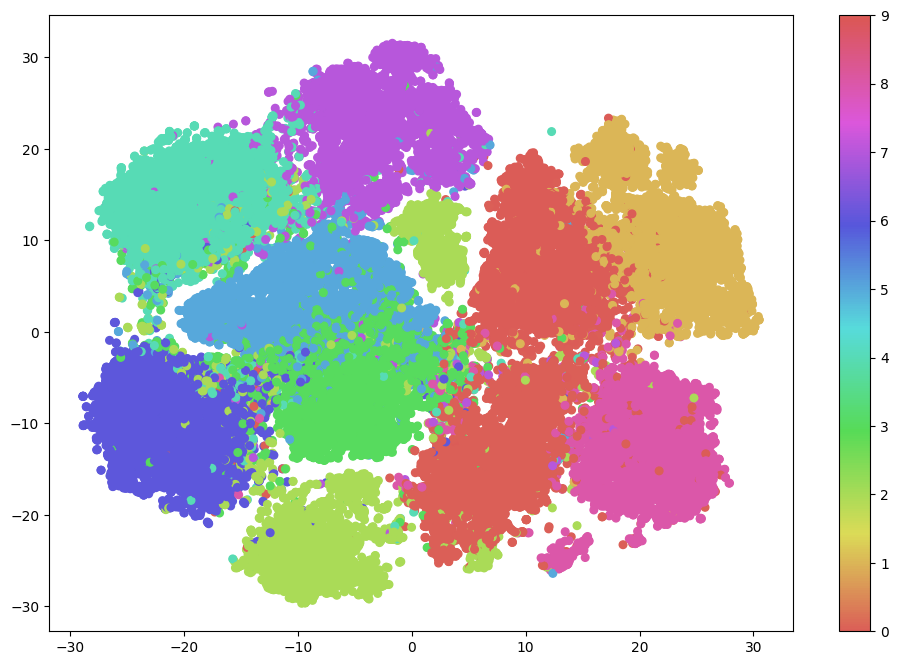

In [7]:
cmap = sns.hls_palette(as_cmap = True)
f, ax = plt.subplots(figsize = (12, 8))
points = ax.scatter(features[:, 0], features[:, 1], c = labels.numpy(), s = 30, cmap = cmap)
f.colorbar(points)
plt.show()